In [525]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import sklearn
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import yaml

import mscproject.models as mod
import mscproject.experiment as exp

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

In [526]:
# Matplotlib Settings
plt.style.use("seaborn-whitegrid")
plt.style.use("seaborn-paper")

FONT_SIZE = 12

# Set plot font size
plt.rcParams.update({"font.size": 8})

# Set axis label font size
plt.rcParams.update({"axes.labelsize": 10})

# Set legend font size
plt.rcParams.update({"legend.fontsize": 10})

# Set tick label font size
plt.rcParams.update({"xtick.labelsize": 9})

# Set tick label font size
plt.rcParams.update({"ytick.labelsize": 9})

# Set figure title font size
plt.rcParams.update({"axes.titlesize": FONT_SIZE})

In [527]:
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

In [528]:
edges_pre_df = pd.read_parquet(conf_dict["edges"])

In [529]:
edges_post_df = pd.read_parquet(conf_dict["edges_features"])

## Graph Statistics

<AxesSubplot:ylabel='Frequency'>

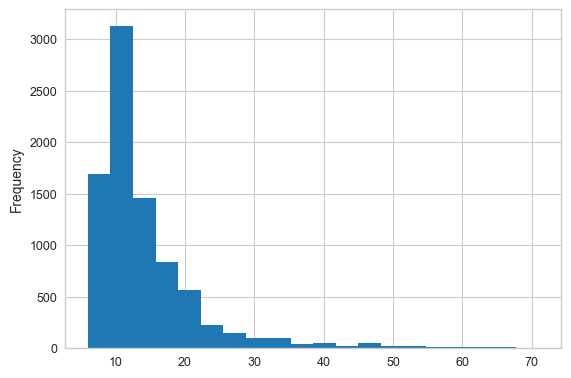

In [567]:
# Get component sizes
component_sizes_pre = edges_pre_df.groupby("component").agg({
    "src": "count"
})
# Select 99% of components
component_sizes_pre = component_sizes_pre.sort_values("src", ascending=True)
component_sizes_pre = component_sizes_pre.iloc[:int(len(component_sizes_pre) * 0.99)]
component_sizes_pre["src"].plot.hist(bins=20, label="Normal")

In [570]:
graph_post = nx.from_pandas_edgelist(edges_post_df, "src", "dst")

In [574]:
# Get connected components
components_post = list(nx.connected_components(graph_post))
# Assign components to edges
edges_post_df["component"] = edges_post_df["src"].apply(
    lambda x: [i for i, c in enumerate(components_post) if x in c][0]
)

<AxesSubplot:ylabel='Frequency'>

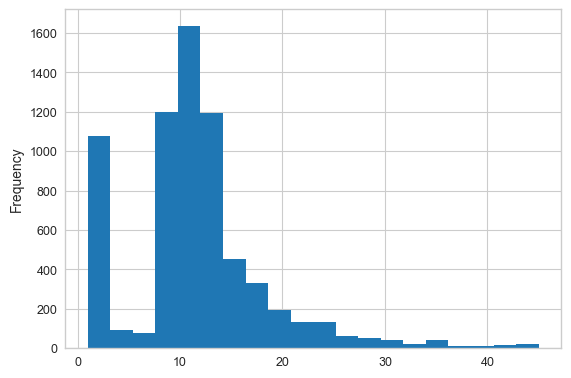

In [575]:
# Get component sizes
component_sizes_post = edges_post_df.groupby("component").agg({
    "is_anomalous": "sum",
    "src": "count"
})
# Select 99% of components
component_sizes_post = component_sizes_post.sort_values("src", ascending=True)
component_sizes_post = component_sizes_post.iloc[:int(len(component_sizes_post) * 0.99)]
component_sizes_post["src"].plot.hist(bins=20, label="Normal")

In [579]:
component_sizes_post

,is_anomalous,src
component,,
5111,1,1
4932,1,1
2783,1,1
4925,1,1
821,1,1
...,...,...
3346,0,45
444,7,45
4677,1,45


In [585]:
component_sizes_pre.groupby("src").size().sort_index()

src
6        3
7        4
8       28
9     1652
10    1417
      ... 
67       5
68       4
69       1
70       1
71       1
Length: 66, dtype: int64

In [586]:
component_sizes_post.groupby("src").size().sort_index()

src
1      728
2      226
3      125
4       55
5       39
6       41
7       34
8       60
9     1140
10    1025
11     613
12     496
13     387
14     310
15     248
16     204
17     169
18     161
19      92
20     100
21      79
22      54
23      57
24      42
25      36
26      30
27      32
28      31
29      19
30      20
31      20
32      11
33      10
34      19
35      13
36      11
37       6
38       5
39       3
40      10
41      10
42       5
43       8
44       3
45       8
dtype: int64

In [578]:
component_sizes_post.groupby("src").agg({
    "is_anomalous": "sum"
})

,is_anomalous
src,
1,728
2,325
3,196
4,95
5,71
6,71
7,39
8,60
9,89


## Anomaly Simulation

In [532]:
graph_edges_post = edges_post_df.query("component == 23")
graph_edges_post

,component,src,dst,interestedPartyIsPerson,minimumShare,is_anomalous
335,23,2258222399048453312,11395388473527546194,False,75.0,True
3542,23,7777674229742200955,2993799137589768883,False,75.0,False
3543,23,7777674229742200955,3121981569988026883,False,75.0,False
3544,23,7777674229742200955,3436044742148301739,False,75.0,False
3546,23,15507582945687881946,15327826988772839815,False,75.0,False
3548,23,7777674229742200955,16269176336766539906,False,75.0,False
3549,23,7777674229742200955,15507582945687881946,False,75.0,False
3550,23,7777674229742200955,9750640700739922330,False,75.0,False
3552,23,7777674229742200955,16288797838414460695,False,75.0,False
3553,23,7777674229742200955,16807511370466429520,False,75.0,False


In [533]:
edges_pre_df.query("src == '2258222399048453312'")

,component,src,dst,interestedPartyIsPerson,minimumShare
3551,77309426934,2258222399048453312,17957350210417364187,False,25.0


In [534]:
graph_edges_pre = edges_pre_df.query("component == 77309426934").sort_values("src")

In [535]:
edges_in_pre_not_in_post = graph_edges_pre.query("src not in @graph_edges_post.src.values")
edges_in_pre_not_in_post

,component,src,dst,interestedPartyIsPerson,minimumShare
3558,77309426934,12193340053346509882,5906392310761780345,True,25.0
3547,77309426934,14144852946696025909,17957350210417364187,True,50.0
3555,77309426934,14144852946696025909,5906392310761780345,True,25.0
3545,77309426934,4875486011478224347,5906392310761780345,True,25.0


In [536]:
graph_pre = nx.DiGraph()
graph_pre.add_nodes_from(graph_edges_pre["src"].unique())
graph_pre.add_nodes_from(graph_edges_pre["dst"].unique())
graph_pre.add_edges_from(graph_edges_pre[["src", "dst"]].values)

In [537]:
graph_post = nx.DiGraph()
graph_post.add_nodes_from(graph_edges_post["src"].unique())
graph_post.add_nodes_from(graph_edges_post["dst"].unique())
graph_post.add_edges_from(graph_edges_post[["src", "dst"]].values)

In [538]:
node_c = "lightblue"
new_node_c = "lightgreen"
dropped_node_c = "lightpink"
anomalous_node_c = "darkorange"

edge_c = "lightgrey"
new_edge_c = "green"
dropped_edge_c = "red"

# new_edge_c = edge_c
# dropped_edge_c = edge_c


In [539]:
graph_pre.nodes

NodeView(('12193340053346509882', '14144852946696025909', '15507582945687881946', '2258222399048453312', '4875486011478224347', '7777674229742200955', '5906392310761780345', '17957350210417364187', '15327826988772839815', '11801961692943090600', '8939346425478313301', '9133034333592821249', '16807511370466429520', '2993799137589768883', '13900102674092328292', '9750640700739922330', '16269176336766539906', '3436044742148301739', '3121981569988026883', '16288797838414460695'))

In [540]:
i = 168
print(i)
pos = nx.drawing.spring_layout(graph_pre, seed=i, iterations=100, k=0.8)

NODE_SIZE = 100

168


In [541]:
anomaly_id = "2258222399048453312"
pos[anomaly_id] = [-0.40 ,  0.21]

In [542]:
def plot_pre(ax):

    edge_colours = [
        edge_c for u, v in graph_pre.edges
    ]
    node_colours = [
        node_c for n in graph_pre.nodes
    ]

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_pre,
        pos=pos,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_pre.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax
    )

In [543]:
def plot_mid(ax):
    # Colour edges that are in the pre graph but not in the post graph
    edge_colours = [
        dropped_edge_c if (u) == "2258222399048453312" else edge_c for u, v in graph_pre.edges
    ]
    node_colours = [
        node_c if n in graph_post.nodes else dropped_node_c for n in graph_pre.nodes
    ]

    # Set colour for node 225
    idx = next(i for i, j in enumerate(graph_pre.nodes) if j == "2258222399048453312")
    node_colours[idx] = anomalous_node_c

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_pre,
        pos=pos,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_pre.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax
    )

In [544]:
def plot_post(ax):
    pos2 = {**pos, "11395388473527546194": pos["17957350210417364187"]}

    # Colour edges in the post graph that are not in the pre graph
    edge_colours = [
        new_edge_c if u == "2258222399048453312" else edge_c for u, v in graph_post.edges
    ]
    node_colours = [
        node_c if n in graph_pre.nodes else new_node_c for n in graph_post.nodes
    ]

    # Set colour for node 225
    idx = next(i for i, j in enumerate(graph_post.nodes) if j == "2258222399048453312")
    node_colours[idx] = anomalous_node_c

    # pos = nx.drawing.spring_layout(graph_intermediate, iterations=1000, seed=i)
    nx.draw(
        graph_post,
        pos=pos2,
        edge_color=edge_colours,
        node_color=node_colours,
        # labels={n: n[:3] for n in graph_post.nodes},
        node_size=NODE_SIZE,
        # font_size=8,
        # font_color="black",
        ax=ax
    )

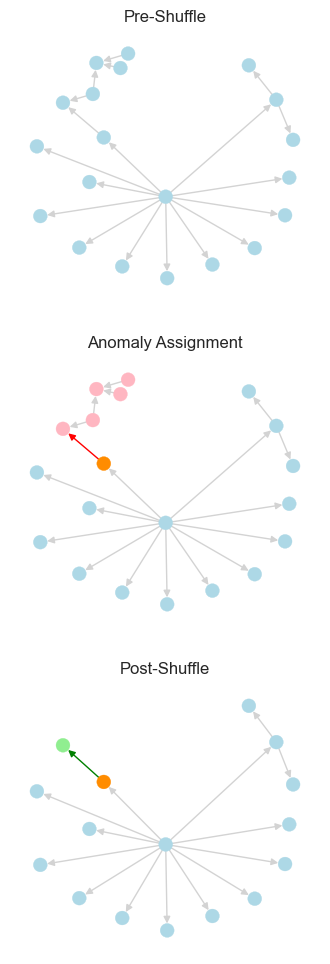

In [545]:
fig, axes = plt.subplots(3, 1, figsize=(4, 12))
axes[0].set_title("Pre-Shuffle")
axes[1].set_title("Anomaly Assignment")
axes[2].set_title("Post-Shuffle")

plot_pre(axes[0])
plot_mid(axes[1])
plot_post(axes[2])

fig.savefig("figures/anomaly-simulation.png", dpi=300, bbox_inches="tight")
